# Explainable Artificial Intelligence (XAI)

Una vez que tenemos desarrollado un modelo de ML, dependiendo de la aplicación puede resultar de interés conocer por qué el modelo se comporta de la forma en que lo hace. Esto es, conocer qué variables están teniendo un mayor efecto sobre la salida, cuales tienen un efecto positivo y cuales uno negativo, etc.  

Esta es una tarea necesaria en la última etapa de validación de nuestro modelo, antes del despliegue.  


Los modelos matemáticos cuyo comportamiento no es interpretable se conocen como modelos de caja negra. En algunas aplicaciones, como modelos de scoring crediticio, modelos que predicen culpabilidad en juicios, etc. Los modelos son auditados y deben ser explicables, ya que ciertas features relacionadas al genero, edad, etnicidad, etc. No pueden ser tenidas en cuenta ya que no sería ético. 

**Relación de compromiso: explicabilidad - precisión** 

En líneas generales podemos identificar que a medida que una mayor complejidad de nuestro modelo nos permite obtener mejores métricas de evaluación, también disminuye la interpretrabilidad del comportamiento.

### ¿Qué es explicabilidad en AI (XAI)? 

**Es un conjunto de herramientas y métodos que nos permiten interpretar de una forma comprensible para humanos, las predicciones realizadas por modelos de machine learning.**

## Tipos de métodos de explicabilidad 

Existen distintos tipos de enfoques que podemos aplicar para aportar mayor explicabilidad a nuestros modelos, estos se pueden agrupar teniendo en cuenta lo siguiente:  

* **Métodos previos al entrenamiento del modelo**: son criterios que podemos aplicar antes del entrenamiento como restringir la cantidad de features, eliminar ciertas features para disminuir la complejidad, etc.  

* **Métodos posteriores al entrenamiento del modelo**: son métodos que se aplican evaluando las predicciones brindadas por el modelo.  


* **Métodos específicos para ciertos tipos de modelos y otro agnósticos**, es decir que pueden ser utilizados independientemente de la arquitectura del modelo.  

 

Métodos que brindan una explicación del comportamiento **global** del modelo, mientras que otros lo hacen de forma **local** para cada predicción. 

## Partial Dependency Plots (PDP)

Es una manera gráfica de ver la contribución marginal promedio de cada feature sobre el target.   

Es útil porque nos muestra si la relación que hay entre una determinada característica del modelo es lineal, monótona o más compleja.  

Una de las suposiciones en las cuales se basa este método es que las características que no están siendo evaluadas en los PDP no están correlacionadas con las que sí se están evaluando. 

**Ventajas**: 

* PDP son gráficos muy fácil de entender para stakeholders 

**Desventajas**: 

* Su uso está limitado a dos features como máximo 

* La suposición de independencia es muy considerable 

* Solo muestra contribuciones marginales, por lo que efectos compuestos no son visibles. 

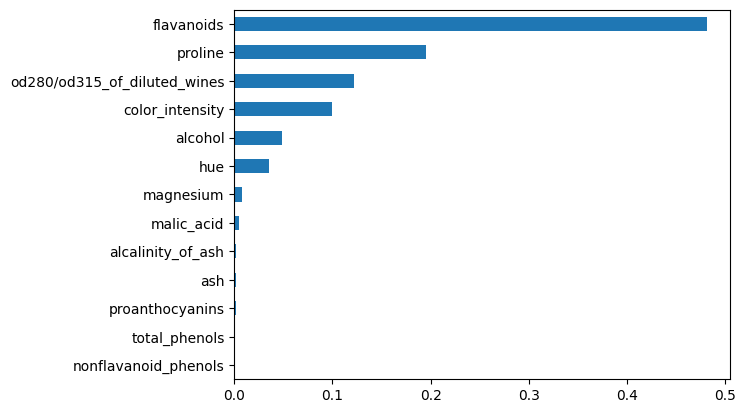

In [2]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor

# Set some pandas options
import matplotlib
#matplotlib.rcParams['text.color'] = 'black'
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = '{:.4f}'.format

raw_data = load_wine()
df = pd.DataFrame(np.c_[raw_data['data'], raw_data['target']],
                  columns= np.append(raw_data['feature_names'], ['target']))

#%%md Train a simple model
y = df.target
X = df.drop('target', axis=1)

# Train a model
rf = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
rf.fit(X, y)

# Print the feature importances, standard after a tree-based model 
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh') 
plt.style.use('seaborn-v0_8-bright')

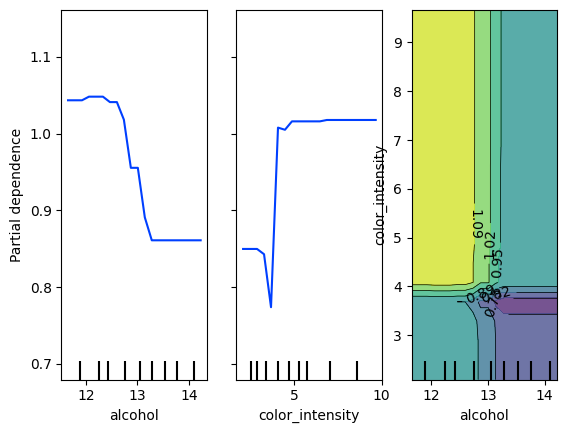

In [4]:

#%%md
### Partial dependency plots

#%%md Partial dependency plots shows how the average prediction changes as you change the feature(s) you are plotting. 
#%%md We then see if the relationship between the feature and the target is monotonic, linear, etc. 

features = ['alcohol', 'color_intensity', ('alcohol', 'color_intensity')]
#fig, ax = plt.subplots(figsize=(20, 10))

PartialDependenceDisplay.from_estimator(estimator=rf, target=y,
                        X=X, #raw features data
                        features=features, grid_resolution=20) #columns we want to show
                                                
fig.suptitle('Partial dependence for alcohol, color intensity and their combination')
fig.subplots_adjust(wspace=0.4, hspace=0.3)

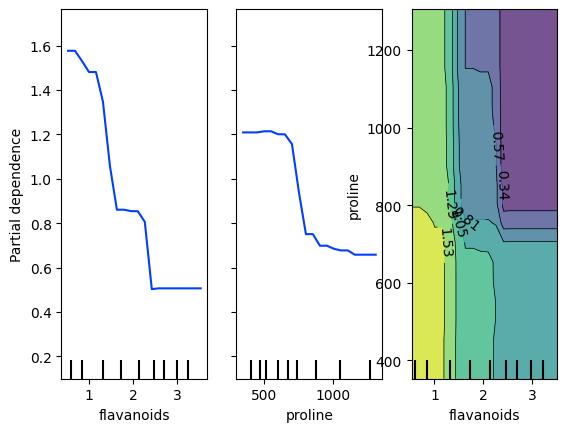

In [5]:
features = ['flavanoids', 'proline', ('flavanoids', 'proline')]


PartialDependenceDisplay.from_estimator(estimator=rf, target=y,
                        X=X, #raw features data
                        features=features, grid_resolution=20) #columns we want to show
                                                
fig.suptitle('Partial dependence for alcohol, color intensity and their combination')
fig.subplots_adjust(wspace=0.4, hspace=0.3)

## Individual Conditional Expectation (ICE)

Son una forma de visualizar y comprender cómo el valor esperado de la variable de respuesta cambia con respecto a una variable específica, manteniendo las demás variables constantes. Es decir, para cada fila de nuestro dataset, se dejan el resto de las variables fijas y se varía el valor de la característica bajo estudio.  

Cada línea de un gráfico ICE representa el cambio en el valor esperado de la variable de respuesta para una observación individual a medida que una variable predictora específica varía.  


*El PDP se obtiene a partir de promediar los resultados del ICE.* 

Al igual que en el PDP, se asume que la feature bajo estudio no se encuentra correlacionada con el resto de las variables del dataset. 

In [6]:
from time import time

def plot_ICE(feature_1, feature_2):
    common_params = {
                        "subsample": 50,
                        "n_jobs": 2,
                        "grid_resolution": 20,
                        "random_state": 0,
                    }

    print("Computing partial dependence plots and individual conditional expectation...")
    tic = time()
    _, ax = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

    features_info = {
        "features": [feature_1, feature_2],
        "kind": "both",
        "centered": True,
    }

    display = PartialDependenceDisplay.from_estimator(
        estimator=rf,
        X=X,
        **features_info,
        ax=ax,
        **common_params,
    )
    print(f"done in {time() - tic:.3f}s")
    _ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

Computing partial dependence plots and individual conditional expectation...
done in 3.588s


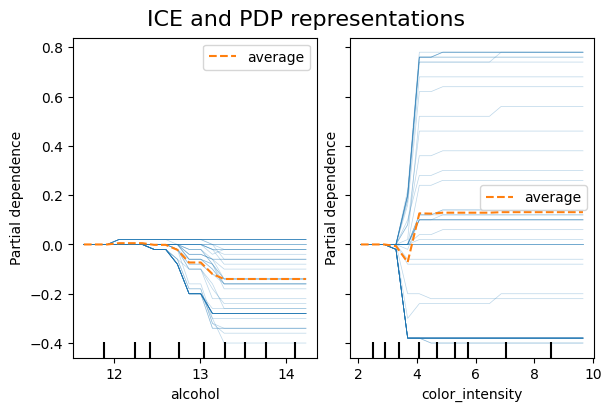

In [7]:
plot_ICE('alcohol', 'color_intensity')

Computing partial dependence plots and individual conditional expectation...
done in 0.463s


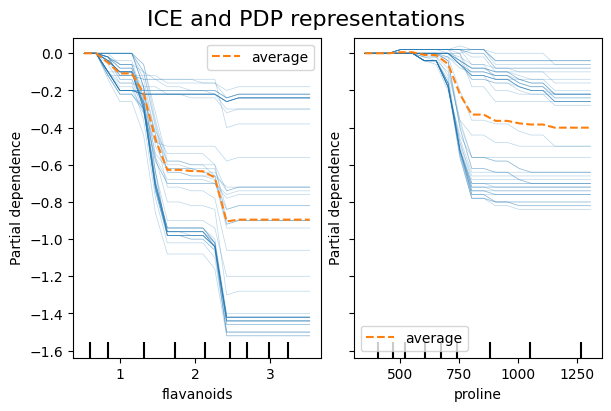

In [8]:
plot_ICE('flavanoids', 'proline')

# GLOBAL explanations

Este enfoque hace referencia a encontrar una explicación del comportamiento GLOBAL del modelo. Existen distintas técnicas, una de ellas puede ser la conocida como Surrogate Models. 

## Surrogate Model

consisten en entrenar un modelo de caja negra que satisfaga las necesidades predictivas del problema. Una vez que el modelo predictor se encuentra entrenado, un modelo más "transparente" o más facilmente explicable, es entrenado sobre las predicciones del modelo de caja negra.   

A partir de la interpretabilidad otorgada por este último modelo de menor complejidad, podemos obtener una visión global de por qué el modelo de caja negra se comporta de cierta manera.  

Para validar que los resultados obtenidos sean correctos, debemos chequear que las métricas obtenidas por el segundo modelo sean adecuadas.  


**Ventajas** 

Es un método fácil de implementar, flexible y es muy sencillo de interpretar y explicar 

 
**Desventajas** 

La explicabilidad que obtenemos de este método, está sujeta a que tanto se ajustan las predicciones del segundo modelo a las originales. Es un método que nos da una idea global aproximada.  

No siempre es claro que tan buenas tienen que ser las métricas que evalúan el modelo surrogado para poder adoptar los resultados obtenidos.  

[Text(0.5, 0.875, 'flavanoids <= 1.575\nsquared_error = 0.566\nsamples = 178\nvalue = 0.935'),
 Text(0.25, 0.625, 'color_intensity <= 3.825\nsquared_error = 0.149\nsamples = 62\nvalue = 1.758'),
 Text(0.125, 0.375, 'malic_acid <= 3.16\nsquared_error = 0.004\nsamples = 13\nvalue = 1.038'),
 Text(0.0625, 0.125, 'squared_error = 0.001\nsamples = 12\nvalue = 1.023'),
 Text(0.1875, 0.125, 'squared_error = -0.0\nsamples = 1\nvalue = 1.22'),
 Text(0.375, 0.375, 'flavanoids <= 1.4\nsquared_error = 0.014\nsamples = 49\nvalue = 1.949'),
 Text(0.3125, 0.125, 'squared_error = 0.004\nsamples = 47\nvalue = 1.969'),
 Text(0.4375, 0.125, 'squared_error = 0.032\nsamples = 2\nvalue = 1.48'),
 Text(0.75, 0.625, 'proline <= 755.0\nsquared_error = 0.235\nsamples = 116\nvalue = 0.496'),
 Text(0.625, 0.375, 'alcohol <= 13.175\nsquared_error = 0.02\nsamples = 56\nvalue = 0.966'),
 Text(0.5625, 0.125, 'squared_error = 0.002\nsamples = 51\nvalue = 0.995'),
 Text(0.6875, 0.125, 'squared_error = 0.107\nsamples = 

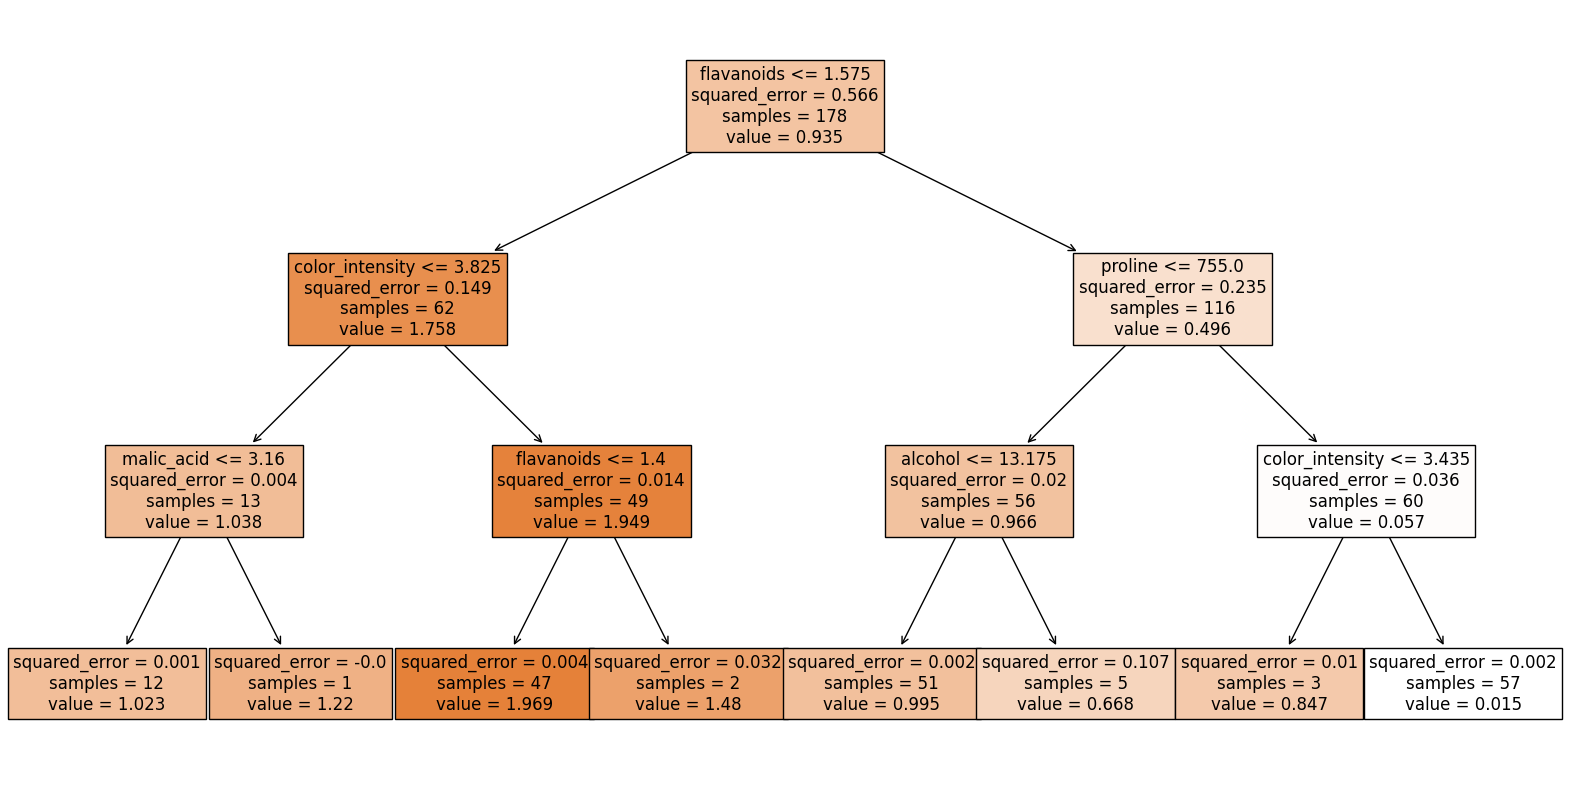

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

predictions = rf.predict(X)
dt = DecisionTreeRegressor(random_state = 100, max_depth=3)
# We fit the shallow tree to the matrix X and the predictions of the random forest model 
dt.fit(X, predictions)

fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(dt, feature_names=list(X.columns), precision=3, 
           filled=True, fontsize=12, impurity=True)

In [10]:
#%%md We need to keep track of how well the surrogate model approximates the black box model. One goos way to do that is to keep track of the R-squared for example. 

dt.score(X, predictions)

0.9896258633875332

## Feature importance

Feature importance es un método que comunmente es propio de los modelos basados en árboles, pero que también puede ser calculado para otros tipos de arquitecturas con alguna librería externa.  

El concepto de feature importance es conocer, cuanto varia una determinada métrica del modelo al cambiar el valor de una de las features de entrada. Este enfoque es conocido como Permutación y consiste en variar aleatoriamente el valor de una feature y ver el impacto sobre la métrica de evaluación. A medida que el impacto es mas grande, mayor es la importancia de esa feature.  

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

# Train a model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# n_repeats is an argument which says how many times to permute each feature, with default 5
results = permutation_importance(lin_reg, X, y, scoring='neg_mean_squared_error', random_state=0)
print(results)

# get importance
importance = results.importances_mean

# put importances in a data frame and sort in decreasing order    
feat_imp_df = pd.DataFrame(importance, index=X.columns, columns=['feature'])
feat_imp_df.sort_values(by='feature', ascending=False)

{'importances_mean': array([1.44827409e-02, 2.86421374e-03, 3.07253796e-03, 3.52489282e-02,
       2.59126718e-05, 1.64522086e-02, 2.85621843e-01, 2.06306263e-03,
       8.85760554e-04, 6.62994708e-02, 3.07529973e-03, 7.98136434e-02,
       9.10915408e-02]), 'importances_std': array([0.00323498, 0.00045935, 0.00097895, 0.00651113, 0.00010818,
       0.00350601, 0.0153469 , 0.00159399, 0.00053704, 0.00642684,
       0.00086213, 0.00564449, 0.0055919 ]), 'importances': array([[ 1.12620890e-02,  1.88323962e-02,  1.22131808e-02,
         1.21176998e-02,  1.79883386e-02],
       [ 3.11002747e-03,  3.52845908e-03,  2.81490269e-03,
         2.13341773e-03,  2.73426175e-03],
       [ 3.81618693e-03,  3.25690902e-03,  4.30908852e-03,
         2.39828695e-03,  1.58221836e-03],
       [ 2.97046604e-02,  3.94492232e-02,  3.56271264e-02,
         2.67045425e-02,  4.47590887e-02],
       [-2.06070278e-08, -2.60058309e-05,  2.38430875e-04,
        -6.27547522e-05, -2.00863259e-05],
       [ 2.2801895

,feature
flavanoids,0.2856
proline,0.0911
od280/od315_of_diluted_wines,0.0798
color_intensity,0.0663
alcalinity_of_ash,0.0352
total_phenols,0.0165
alcohol,0.0145
hue,0.0031
ash,0.0031
malic_acid,0.0029


# LOCAL explanations

Este enfoque se basa en explicar las predicciones de manera individual en vez del comportamiento general del modelo como se vio en el caso de Global explanations.  

Uno de los métodos que utilizan este enfoque se llama: Local interpretable model-agnostic explanations (LIME)  

### LIME

Es un algoritmo que utiliza permutación para genera un nuevo dataset 

 

* Selección de la instancia: Se elige la instancia de datos para la cual se desea explicar la predicción del modelo. 

* Generación de muestras vecinas: Se generan muestras ligeramente modificadas alrededor de la instancia seleccionada. Estas modificaciones se realizan mediante perturbaciones controladas, como eliminar o cambiar valores en las características de la instancia original. 

* Predicciones de las muestras vecinas: Las muestras vecinas se pasan al modelo de aprendizaje automático y se obtienen las predicciones correspondientes. 

* Construcción del modelo interpretable: Se ajusta un modelo interpretable (generalmente más simple) en las muestras vecinas generadas. Esto se hace para comprender cómo el modelo interpretable está tomando decisiones basadas en características seleccionadas. 

* Cálculo de la importancia de características: Se calcula la importancia de las características en el modelo interpretable para la instancia seleccionada. Esto proporciona una indicación de qué características están influyendo más en la predicción del modelo original. 

* Generación de explicaciones: Se generan explicaciones basadas en la importancia de características calculada. Estas explicaciones pueden ser en forma de puntuaciones, resúmenes textuales, visualizaciones, etc. 

In [13]:
import lime
 
from lime.lime_tabular import LimeTabularExplainer
# Define a Lime explainer
explainer = LimeTabularExplainer(X, mode='regression', 
                                 feature_names=list(X.columns), 
                                 random_state=42, 
                                 discretize_continuous=False,
                                 kernel_width=0.2) 

In [14]:
exp = explainer.explain_instance(X.iloc[0,:].values, 
                                 rf.predict, num_features=8)
                                 
print(exp.local_pred)

[1.14017684e-31]


c:\Users\alexb\anaconda3\envs\amq2\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


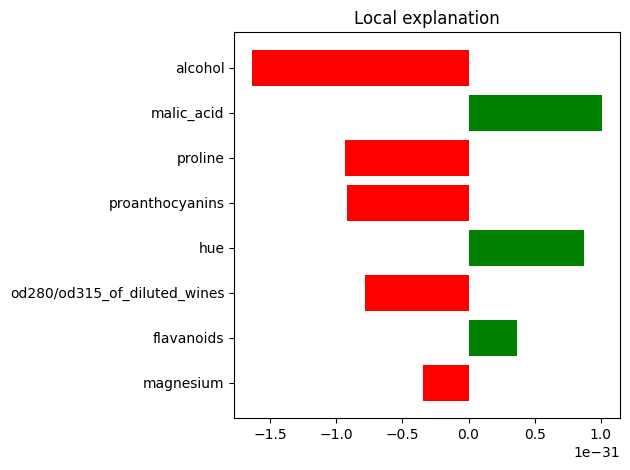

In [15]:
exp.as_pyplot_figure()
plt.tight_layout()

## SHAP values

Los SHAPley values indican que tanto cada feature "empuja" el valor de la predicción por encima o por debajo del valor promedio del target en el dataset.  


El procedimiento es el siguiente: 

* Se define un valor de base para el target, comunmente el promedio del dataset.  

* Se crean múltiples "coaliciones", que son escenarios donde se van variando los valores asociados a cada feature para ver cómo impactan en el target.  

* Se promedian las "importancias" calculadas en el ítem anterior para obtener un valor promedio para cada feature en esa realización en particular  

c:\Users\alexb\anaconda3\envs\amq2\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\alexb\anaconda3\envs\amq2\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

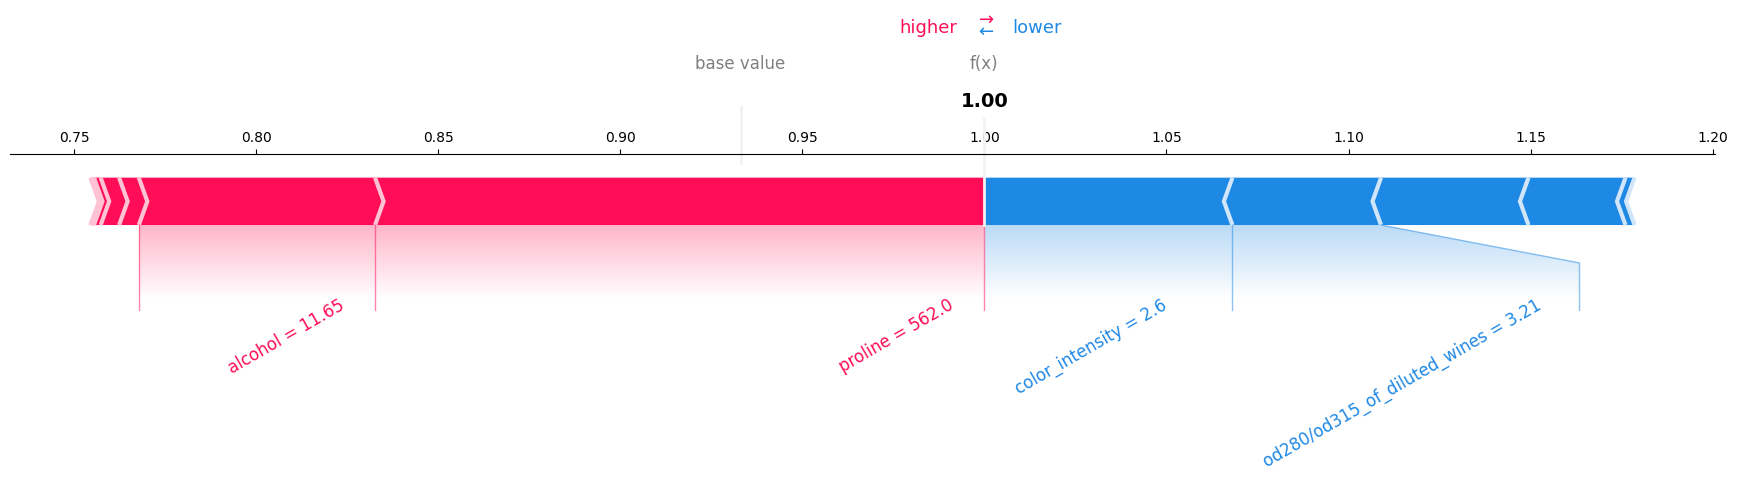

In [17]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
dataset_instance = 87
shap.force_plot(explainer.expected_value, shap_values[dataset_instance,:], X.iloc[dataset_instance,:], matplotlib=True, figsize=(22, 4), \
                text_rotation=30)

In [18]:
# Perhaps the exact values are not readable from the plot, we can extract them in a table 
shap_vals = shap_values[dataset_instance, :]
feature_importance = pd.DataFrame(list(zip(X.columns, shap_vals)), columns=['column_value','shap_vals'])
feature_importance.sort_values(by=['shap_vals'], ascending=False,inplace=True)
feature_importance

,column_value,shap_vals
12,proline,0.1673
0,alcohol,0.0649
5,total_phenols,0.0054
4,magnesium,0.0051
1,malic_acid,0.0018
2,ash,0.0005
3,alcalinity_of_ash,0.0004
7,nonflavanoid_phenols,0.0001
8,proanthocyanins,-0.0025
10,hue,-0.0266


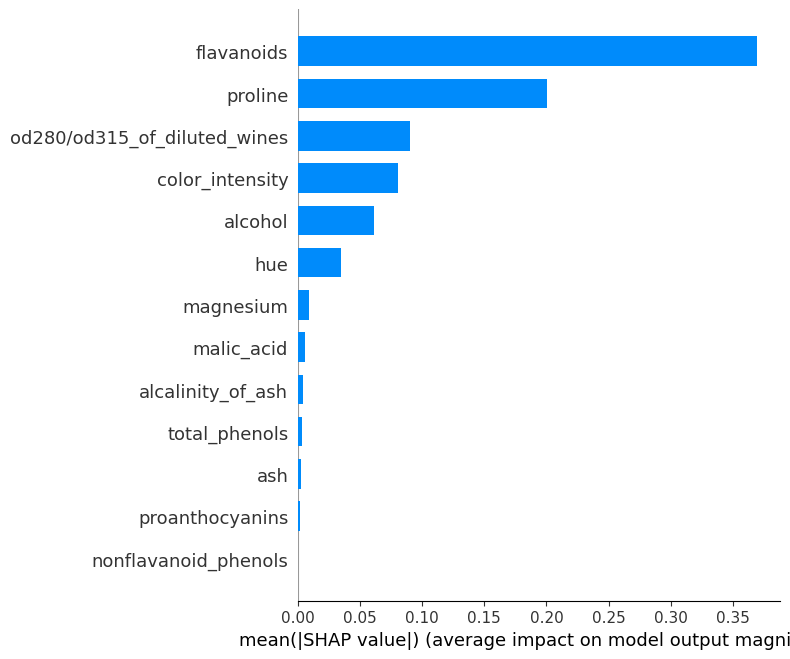

In [19]:
# Plot the features'average impact on the model output's magnitude
shap.summary_plot(shap_values, X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


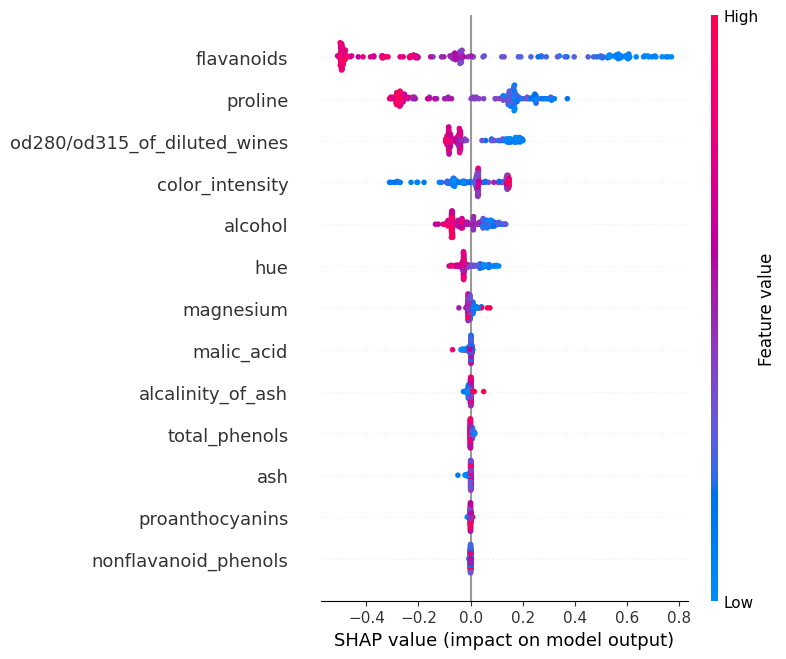

In [20]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

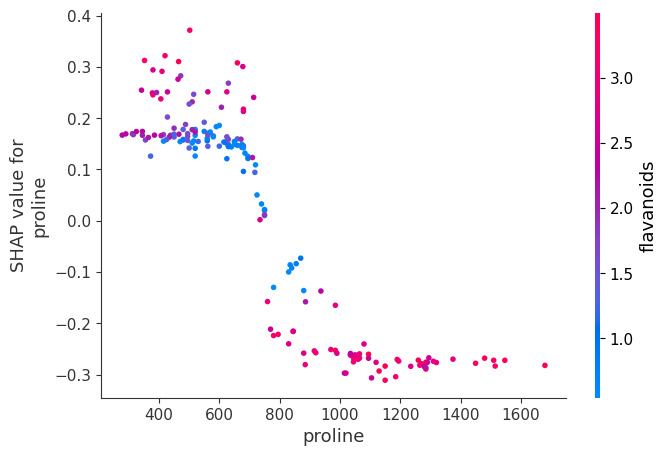

In [21]:
# The first argument is the feature of interest as an integer or string, followed by the shap_values and X matrix
shap.dependence_plot('proline', shap_values, X)